# Evaluating GANs
- Challenges that come evaluating GANs
- Alleviate them through Frechet Inception Distance (FID)

## Challenges with Evaluating GANs
- Loss is Uninformative of Performance
    - Loss tess us little about a model's performance
    - Wrt Classifiers, a low loss on a test set is a superior performance
    - A low lowss for the generator or discriminator suggestion that learning has stopped
    
- No Clean Non-Human Metric
    - If the goal is "Generating images that look real to people" then ask people to evaluate
    - However this is difficult and time consuming 
    - There are no perfect discriminator that differentiates from reals from fakes

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
from generator import Generator
from gans_utils import get_noise

### Loading the Pre-trained Model
  *   z_dim: the dimension of the noise vector
  *   image_size: the image size of the input to Inception (more details in the following section)
  *   device: the device type

In [3]:
z_dim = 64
image_size = 299
device = 'cpu'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CelebA('../../', download=True, transform=transform)

Files already downloaded and verified


In [4]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"../../celeba/pretrained_celeba.pth", map_location=torch.device(device))["gen"])
gen = gen.eval()

### Inception-v3 Network
- Inception v3 is an NN trained on ImageNet to classify objects

In [5]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("../../celeba/inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

## Frechet Inception Distance

- FID was proposed as an improvement over Inception Score, also uses Inception-v3 as part of its calculation
- Instead of using classification labels of Inception-V3, It uses output from earlier layer - the layer before the labels
- This layer is called as feature layer
- Research has shown that deep convolutional nn trained on difficult tasks - like classifying many classes, build increasingly sophisticated representations of features going deeper into the network
- For ex. the first few layers may learn to detect different kinds of edges and curves - while the later layers may have neurons that fire in response to human faces
- To get feature layer, replace the final fully connected layer with an identity layer that simply returns whatever input received - unchanged
- This essentially removes the final classiication layer and leaves you with the intermediate ouputs from the layer before

In [6]:
# Replace the final fully-connected (fc) layer with an identity function
# layer to cut of the classification layer and get a feature extractor
inception_model.fc = nn.Identity(100, 100)

In [7]:
test_identity_noise = torch.randn(100, 100)
assert torch.equal(test_identity_noise, inception_model.fc(test_identity_noise))
print('Success!')

Success!


### Frechet Distance

- Frechet distance uses the values from the feature layer for 2 sets of images - reals and fakes
- It compares different statistical properties between them to see how different they are
- FD finds the shortest distance needed to walk along two lines or 2 curves, simultaneously
- Otherwise, minimum leash distance between 2 points

The basic idea is similar for calculating FD between 2 probability distributions - in one dimensional or univariate space

#### Univariate Frechet Distance
Calculate the distance betwenn 2 normal distributions $X$ and $Y$ with means $\mu_x$ and $\mu_y$ and their standard deviations $\sigma_x$ and $\sigma_y$

$$d(X,Y) = (\mu_x - \mu_y)^2 + (\sigma_x - \sigma_y)^2$$

#### Multivariate Frechet Distance
- FID is calculated using covaiance instead of std
- The covariance, which is the multivariate version of variance (the square of std) is represented using a square matrix
- Side length of the square matrix is equal to the number of dimensions
- For ex. feature vectors of 2048 values/weights - the covariance matrix is 2048 x 2048

$$\Sigma = \left(\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right)
$$

- The value at location $(i, j)$ corresponds to the covariance of vector $i$ and vector $j$
- Since the covariance of $i$ with $j$ is equivalent to covariance of $j$ with $i$ - the matrix will always be symmetric wrt diagonal
- The diagonal is covariance of that element with itself 
- In the ex. zeros everywhere except the diagonal - 2 dimensions are independent of one another - ie they are completely unrelated


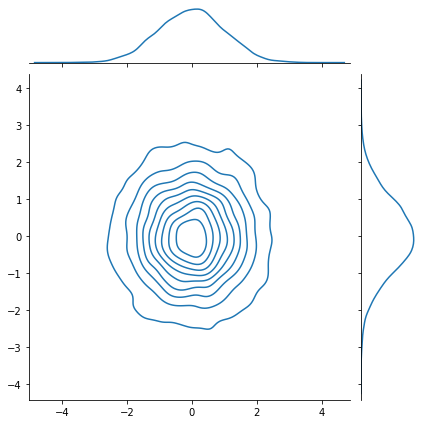

In [8]:
from torch.distributions import MultivariateNormal
import seaborn as sns
mean = torch.Tensor([0, 0])
covariance = torch.Tensor([
    [1, 0],
    [0, 1]
])
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))
res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
plt.show()

$$\Sigma = \left(\begin{array}{cc}
2 & -1\\
-1 & 2
\end{array}\right)
$$

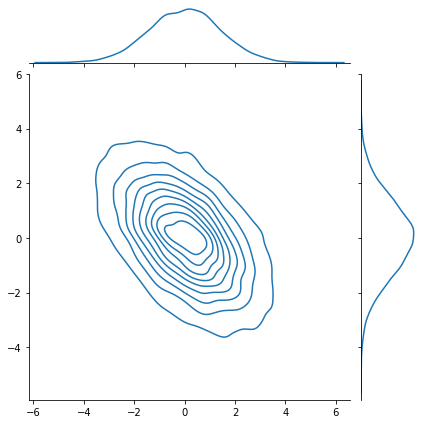

In [9]:
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
plt.show()

Based on the paper, "[The Fréchet distance between multivariate normal distributions](https://core.ac.uk/reader/82269844)" by Dowson and Landau (1982), the Fréchet distance between two multivariate normal distributions $X$ and $Y$ is:

$$d(X, Y) = \Vert\mu_X-\mu_Y\Vert^2 + \mathrm{Tr}\left(\Sigma_X+\Sigma_Y - 2 \sqrt{\Sigma_X \Sigma_Y}\right)$$

Similar to the formula for univariate Fréchet distance, you can calculate the distance between the means and the distance between the standard deviations. However, calculating the distance between the standard deviations changes slightly here, as it includes the matrix product and matrix square root.  Tr  refers to the trace, the sum of the diagonal elements of a matrix.

In [10]:
import scipy

def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [11]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    part_1 = (mu_x - mu_y) @ (mu_x - mu_y)
    part_2 = torch.trace(sigma_x) + torch.trace(sigma_y) - torch.trace(2*matrix_sqrt(sigma_x @ sigma_y))
                                                                      
    return part_1 + part_2

In [12]:
mean1 = torch.Tensor([0, 0])

# This matrix shows independence - there are only non-zero values on the diagonal
covariance1 = torch.Tensor([
    [1, 0],
    [0, 1]
])
dist1 = MultivariateNormal(mean1, covariance1)

mean2 = torch.Tensor([0, 0]) # Center the mean at the origin
covariance2 = torch.Tensor( # This matrix shows dependence 
    [[2, -1],
     [-1, 2]]
)
dist2 = MultivariateNormal(mean2, covariance2)

assert torch.isclose(
    frechet_distance(
        dist1.mean, dist2.mean,
        dist1.covariance_matrix, dist2.covariance_matrix
    ),
    4 - 2 * torch.sqrt(torch.tensor(3.))
)

assert(frechet_distance(
    dist1.mean, dist2.mean,
    dist1.covariance_matrix, dist1.covariance_matrix
).item() == 0)

print('Success!')

Success!


### Putting it all together
- Apply FID to the generator
- Preprocess the image for the inception v3 network

In [13]:
def preprocess(img):
    img = torch.nn.functional.interpolate(
        img, size=(299, 299), mode='bilinear'
    )
    return img

import numpy as np
def get_covariace(features):
    return torch.Tensor(
        np.cov(features.detach().numpy(), rowvar=False)
    )

- Use pre-trained v3 model to compute features of the real and fake images
- With these fetures, get the covariance and means of these features across many samples

In [ ]:
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 512
batch_size = 4

dataloader = DataLoader(
    dataset, batch_size=batch_size,
    shuffle=True
)

cur_samples = 0
# No need to calculate gradients, mem saved
with torch.no_grad(): 
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size):
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to('cpu')
            real_features_list.append(real_features)
            
            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            
            if(cur_samples >= n_samples):
                break
                
    except:
        print("Error in Loop")

/Users/shankar/dev/tools/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [27]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

In [28]:
# Calculate the covariance matrix for the fake and real features
# and also calcuate the means of the feture over the batch - for each feature dimension mean
mu_fake = fake_features_all.mean(dim=0)
mu_real = real_features_all.mean(dim=0)

sigma_fake = get_covariace(fake_features_all)
sigma_real = get_covariace(real_features_all)

In [29]:
tuple(sigma_fake.shape)
fake_features_all.shape
mu_fake.shape
mu_real.shape

torch.Size([2048])

In [30]:



# assert tuple(sigma_fake.shape) == (fake_features_all.shape[1], fake_features_all.shape[1])
# assert torch.abs(sigma_fake[0, 0] - 2.5e-2) < 1e-2 and torch.abs(sigma_fake[-1, -1] - 5e-2) < 1e-2
# assert tuple(sigma_real.shape) == (real_features_all.shape[1], real_features_all.shape[1])
# assert torch.abs(sigma_real[0, 0] - 3.5768e-2) < 1e-4 and torch.abs(sigma_real[0, 1] + 5.3236e-4) < 1e-4
# assert tuple(mu_fake.shape) == (fake_features_all.shape[1],)
# assert tuple(mu_real.shape) == (real_features_all.shape[1],)
# assert torch.abs(mu_real[0] - 0.3099) < 0.01 and torch.abs(mu_real[1] - 0.2721) < 0.01
# assert torch.abs(mu_fake[0] - 0.37) < 0.05 and torch.abs(mu_real[1] - 0.27) < 0.05
# print("Success!")

visualize what the pairwise multivariate distributions of the inception features look like!

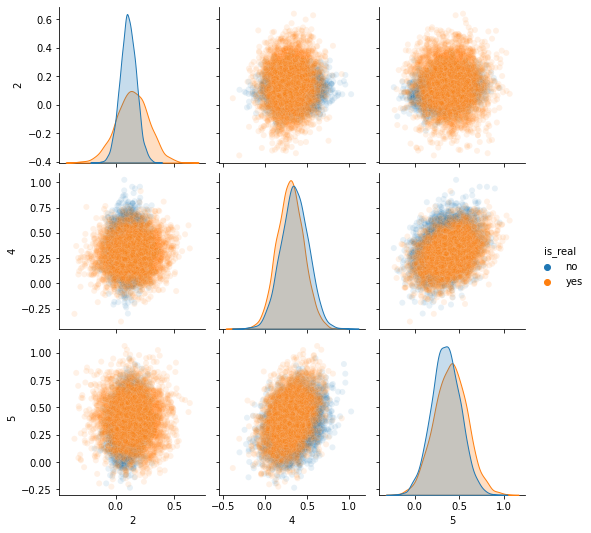

In [31]:
indices = [2, 4, 5]
fake_dist = MultivariateNormal(
    mu_fake[indices], sigma_fake[indices][:, indices]
)
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(
    mu_real[indices], sigma_real[indices][:,indices]
)
real_samples = real_dist.sample((5000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(df, plot_kws={'alpha': 0.1}, hue="is_real")

Lastly, you can use your earlier frechet_distance function to calculate the FID and evaluate your GAN. You can see how similar/different the features of the generated images are to the features of the real images. The next cell might take five minutes or so to run in Coursera.

In [32]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

141.74664306640625


You'll notice this model gets a pretty high FID, likely over 30. Since lower is better, and the best models on CelebA get scores in the single-digits, there's clearly a long way to go with this model. You can use FID to compare different models, as well as different stages of training of the same model.